## Detect GPU hardware and install pytorch, fastai, and other dependencies 

In [0]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/{accelerator}/torch_nightly.html
!pip install fastai

import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

Looking in links: https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html
1.1.0.dev20190418
True
True


In [0]:
!pip install spacy
import spacy.cli
spacy.cli.download("en_core_web_md")


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_md -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')



In [0]:
import fastai
print(fastai.__version__)
from fastai import *
from fastai.text import *
from fastai.core import *

1.0.51


In [0]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Sentiment Data: IMDB movie reviews

In [0]:
path = untar_data(URLs.IMDB_SAMPLE)

In [0]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [0]:
example_review=df.loc[0,'text']
print(example_review)

Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!


## Zipf's Law Example

In [0]:
# get all the words 
words = ''.join(df['text'].values).split()

In [0]:
len(words)

246799

In [0]:
# count the words and rank order them 
from collections import Counter
c=Counter(words)

In [0]:
c['Meg']

3

In [0]:
c.most_common()[:10]

[('the', 12354),
 ('and', 6469),
 ('a', 6451),
 ('of', 6244),
 ('to', 5704),
 ('is', 4120),
 ('in', 3591),
 ('that', 2766),
 ('I', 2460),
 ('this', 2366)]

In [0]:
# get a list of frequencies as a function of rank index  
y=[count[1] for count in c.most_common()]

# take the log of both sides 
log_y, log_x = np.log(y), np.log(np.arange(len(y))+1)



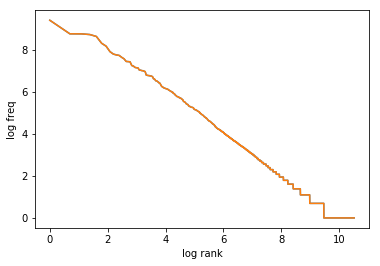

In [0]:
plt.plot(log_x,log_y)
plt.xlabel('log rank')
plt.ylabel('log freq')
plt.plot(log_x,log_y)


## Count-based Classification

In [0]:
# use scikit learn 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [0]:
# convert text labels into binary integer
df['label']=LabelEncoder().fit_transform(df.label)

In [0]:
# split 80/20 into train and test sets 
train_df=df[~df['is_valid']]
test_df=df[df['is_valid']] 

In [0]:
# extract labels and compute count vectors for train and test sets 
vec=CountVectorizer(stop_words='english')

X_train = vec.fit_transform(train_df.text).toarray()
Y_train = train_df.label

X_test = vec.transform(test_df.text).toarray()
Y_test = test_df.label

In [0]:
print(len(X_train[0]))
X_train[0]

16163


array([0, 0, 0, 0, ..., 0, 0, 0, 0], dtype=int64)

In [0]:
nb=MultinomialNB()

In [0]:
nb.fit(X_train,Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
nb.predict([X_test[0]])

array([1])

In [0]:
Y_test.iloc[0]

1

In [0]:
Y_predict = nb.predict(X_test)

In [0]:
print(str(accuracy_score(Y_test,Y_predict)*100)+'%')

79.5%


In [0]:
cm=confusion_matrix(Y_test,Y_predict)

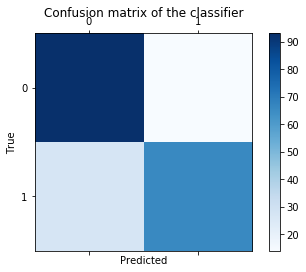

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm,cmap='Blues')
labels =['positive','negative']
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Word Embeddings

In [0]:
# load pretrained word vectors 
import spacy
nlp=spacy.load('en_core_web_sm')

In [0]:
doc = nlp(example_review)

In [0]:
doc[4]

believable

In [0]:
print(doc[4].vector)
print(len(doc[4].vector))

[-1.054349  1.601981 -1.974771  2.142828 ...  0.205527  0.25728  -0.088836  0.390665]
384


In [0]:
# take a few words
tokens = nlp(u'dog cat banana wolf')

# compute pairwise similarity
for token1 in tokens:
    for token2 in tokens:
        print(token1.text, token2.text, token1.similarity(token2))


dog dog 1.0
dog cat 0.54679364
dog banana 0.4000858
dog wolf 0.26444006
cat dog 0.54679364
cat cat 1.0
cat banana 0.5711934
cat wolf 0.29676923
banana dog 0.4000858
banana cat 0.5711934
banana banana 1.0
banana wolf 0.50492144
wolf dog 0.26444006
wolf cat 0.29676923
wolf banana 0.50492144
wolf wolf 1.0


In [0]:
# average of the word vectors for a whole sentence  
print(doc.vector)

[ 0.393058  0.658364  0.620836  1.061359 ... -0.043477  0.117051  0.155752  0.048947]


In [0]:
X_train_emb=[nlp(review).vector for review in train_df.text.values]

In [0]:
X_test_emb=[nlp(review).vector for review in test_df.text.values]

In [0]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()

In [0]:
lr.fit(X_train_emb, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
Y_predict = lr.predict(X_test_emb)

In [0]:
print(str(accuracy_score(Y_test,Y_predict)*100)+'%')

83.0%


## Universal Language Model with Fine Tuning (Toy Example)

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'texts.csv',  vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
# download pretrained LM for finetuning. Trained on wikipedia dataset 

learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [0]:
learn_lm.predict('Once upon a', 5)

'Once upon a Team ( front )'

In [0]:
learn_lm.predict('The quick brown fox jumped over the lazy', 1)

'The quick brown fox jumped over the lazy unit'

In [0]:
learn_lm.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.536210,4.129499,0.300000,00:09
1,4.194678,3.949701,0.314286,00:09
2,3.920634,3.935906,0.300000,00:09


In [0]:
learn_lm.predict('This movie is about', 5)

'This movie is about a woman who is jobs'

In [0]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.751558,3.866713,0.357143,00:12


In [0]:
learn_lm.save_encoder('finetuned_enc')

In [0]:
learn_cl = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_cl.load_encoder('finetuned_enc')

In [0]:
learn_cl.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.634043,0.588078,0.731343,00:13
1,0.572839,0.523473,0.776119,00:12
2,0.528314,0.509173,0.771144,00:11


In [0]:
learn_cl.freeze_to(-2)
learn_cl.fit_one_cycle(3, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.524393,0.644368,0.676617,00:15
1,0.500036,0.437637,0.830846,00:14
2,0.442444,0.424076,0.815920,00:14


In [0]:
learn_cl.unfreeze()
learn_cl.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.366968,0.424128,0.825871,00:26


In [0]:
learn_cl.predict("")

(Category positive, tensor(1), tensor([0.0345, 0.9655]))